<a href="https://colab.research.google.com/github/sAndreotti/MedicalMeadow/blob/main/ATML_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Components

Stefano Quaggio \\
Damiano Ficara \\
Claudio Ricci \\
Stefano Andreotti

# MedicalMeadow ChatBot fine-tuning Llama 3.2 1B
MedicalMeadow is a project focused on training a chatbot using the LLaMA model, fine-tuned with the Medical Meadow dataset. The aim is to develop a robust NLP system capable of answering medical questions effectively.

## Libraries

### Download

In [1]:
!pip install datasets accelerate peft transformers trl==0.12.0 plotly huggingface_hub
!pip install --upgrade smart_open
!pip install --upgrade gensim
!pip install ffmpeg-python
!pip install -U openai-whisper
!pip install scipy librosa unidecode inflect
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install TTS
!pip uninstall -y bitsandbytes
!pip install bitsandbytes
!pip install nltk
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 16.1 MB/s eta 0:00:0

Found existing installation: unsloth 2025.1.5
Uninstalling unsloth-2025.1.5:
  Successfully uninstalled unsloth-2025.1.5
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-fhp3sytp
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-fhp3sytp
  Resolved https://github.com/unslothai/unsloth.git to commit 5dddf27f3ba94506c48251e907031039eecd40d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2025.1.5-py3-none-any.whl size=176838 sha256=8668e25f170757a535758b645d635b2b9a4df5ad58a8140b065acb1fd848cb98
  Stored in directory: /tmp/pip-ephem-wheel-cache-tw081x5u/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Pre

Found existing installation: bitsandbytes 0.45.0
Uninstalling bitsandbytes-0.45.0:
  Successfully uninstalled bitsandbytes-0.45.0
  Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl.metadata (2.9 kB)
Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl (69.1 MB)


### Import

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from trl import SFTTrainer
import re
from gensim.models.word2vec import Word2Vec
import plotly.express as px
import random
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import Subset
from peft import prepare_model_for_kbit_training, LoraConfig
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    AutoModelForSpeechSeq2Seq,
    AutoProcessor,
    pipeline,
    TextStreamer
)
from peft import AutoPeftModelForCausalLM
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tabulate import tabulate

from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only
from TTS.api import TTS
from dotenv import load_dotenv
from huggingface_hub import login
import os

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### Import for audio section

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import scipy
import whisper

import librosa
import soundfile as sf

## Hugging Face settings

In order to carry out operations with Llama and to have authorisations to use it, it is necessary to log in to Hugging Face and make a request to use the template. The HF access token must be saved in an .env file

In [3]:
load_dotenv()
login(token=os.environ.get('HF_TOKEN'))

## Investigate Dataset

This dataset, [Medical Meadow](https://huggingface.co/datasets/medalpaca/medical_meadow_medical_flashcards?row=0), includes a deep understanding of basic medical sciences, clinical knowledge, and clinical skills. The embedded flashcards are created and updated by medical students and cover the entirety of this curriculum, addressing subjects such as anatomy, physiology, pathology, pharmacology, and more. These flashcards frequently feature succinct summaries and mnemonics to aid in learning and retention of vital medical concepts.

In this section, we analyse the dataset under consideration

In [4]:
# Download Medical Meadow dataset from HF
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")

# The dataset is composed by just on split: 'train'
ds = ds['train']
ds

README.md:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

(…)l_meadow_wikidoc_medical_flashcards.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 33955
})

In [5]:
# Analyze the dataset: input, output, instruction
print(ds.features, "\n")
print("Instruction:")
print(f"length: {len(ds['instruction'])}")
print(f"example: {ds['instruction'][0]} \n")

print(f"Input:")
print(f"length: {len(ds['input'])}")
print(f"example: {ds['input'][0]} \n")

print(f"Output:")
print(f"length: {len(ds['output'])}")
print(f"example: {ds['output'][0]} \n")

{'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None), 'instruction': Value(dtype='string', id=None)} 

Instruction:
length: 33955
example: Answer this question truthfully 

Input:
length: 33955
example: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels? 

Output:
length: 33955
example: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels. 



### Some plots about the dataset

In [6]:
# Better usability
instructions = ds['instruction']
input_phrases = ds['input']
output_phrases = ds['output']

Plot about the ditribution of instruction's classes (just 1 class for all instances)

In [ ]:
%matplotlib inline

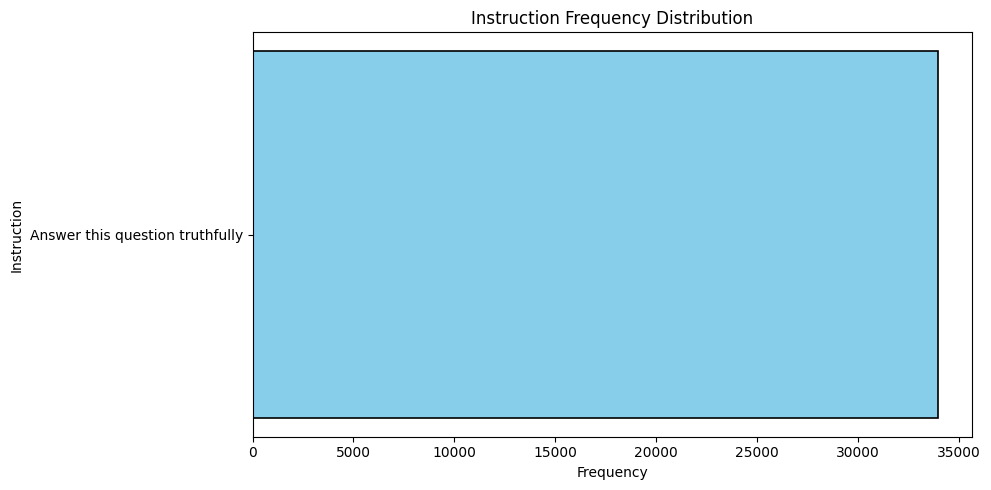

In [ ]:
# Count the frequency of each unique instruction
instruction_counts = {instruction: instructions.count(instruction) for instruction in set(instructions)}

# Sort the instructions by frequency
sorted_instructions = sorted(instruction_counts.items(), key=lambda x: x[1], reverse=True)

# Separate the instructions and their counts for plotting
sorted_instruction_names = [item[0] for item in sorted_instructions]
sorted_instruction_counts = [item[1] for item in sorted_instructions]

# Plotting the frequency of instructions
plt.figure(figsize=(10, 5))

bars = plt.barh(sorted_instruction_names, sorted_instruction_counts, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Instruction Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Instruction')

# Show the plot
plt.tight_layout()
plt.savefig("instruction_frequency_distribution.png")
plt.show()

Two plots about the distribution of the lengths of the instances of the input and output sentences

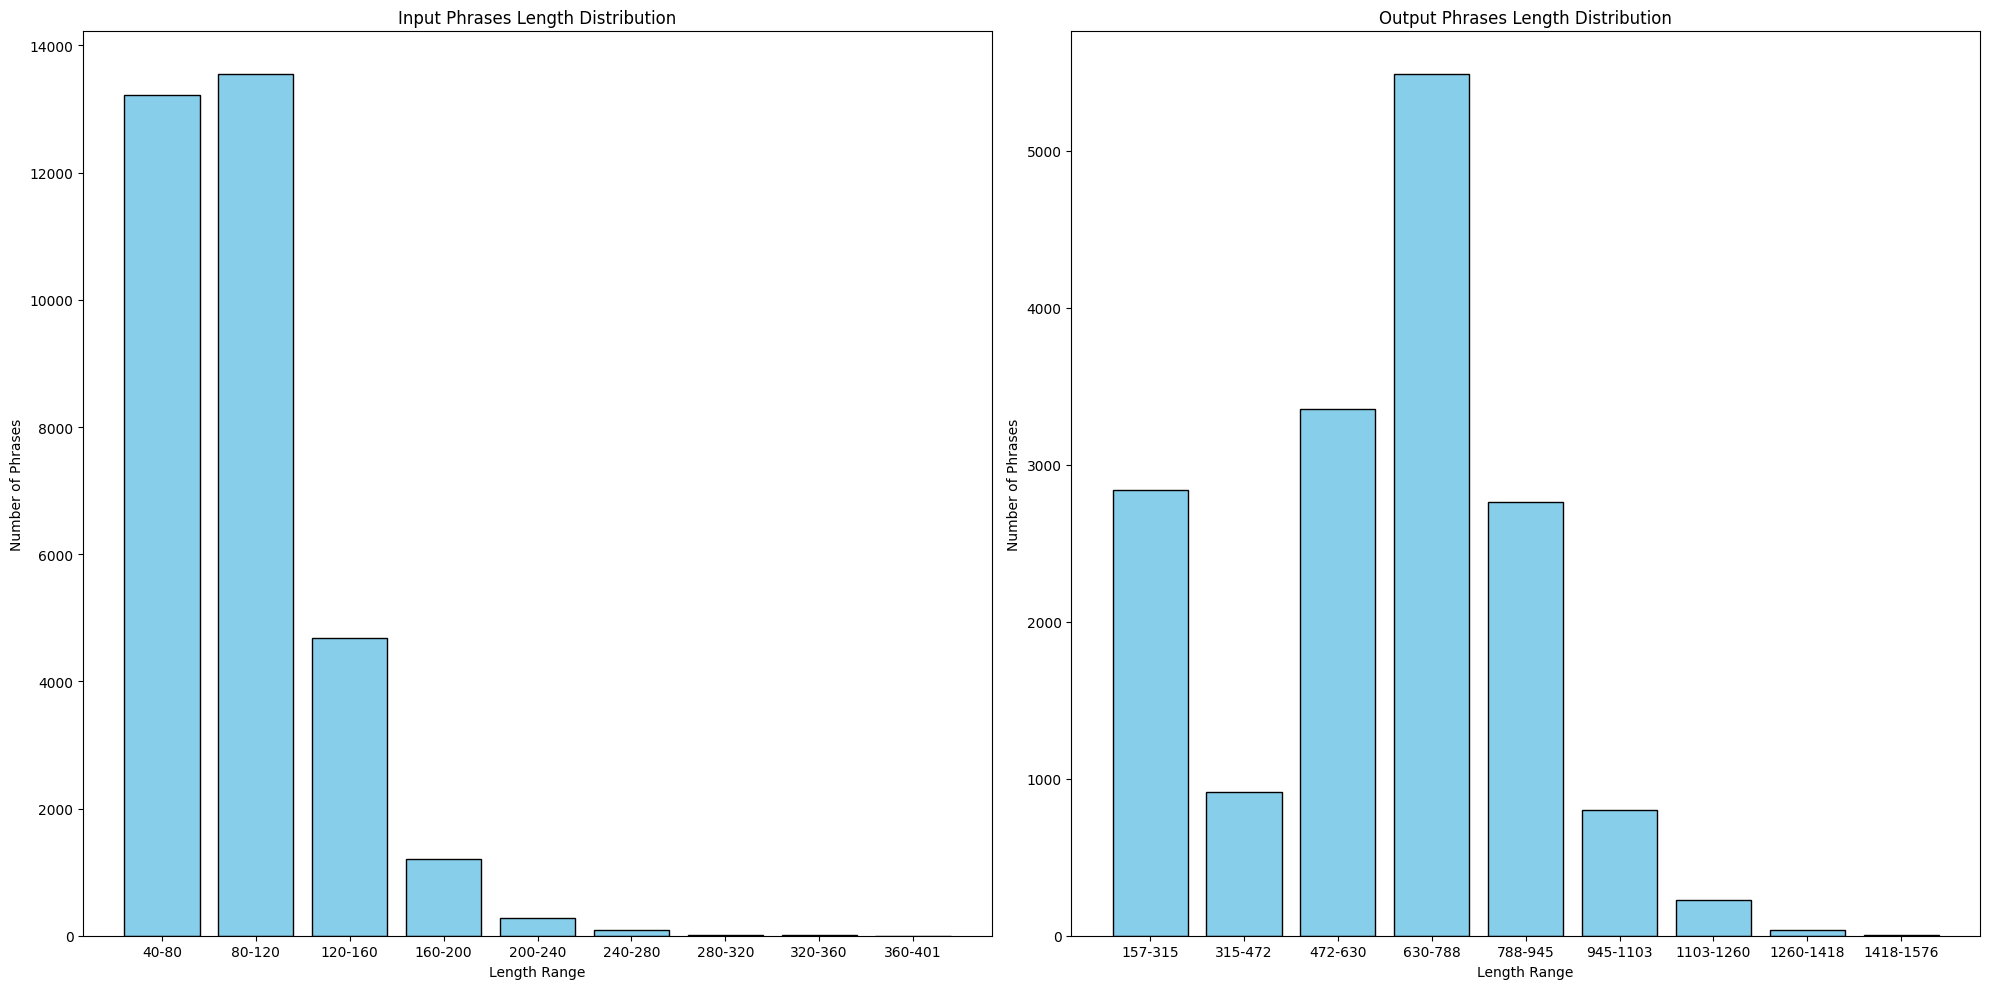

In [ ]:
# Calculate the length of each phrase
input_lengths = [len(phrase) for phrase in input_phrases]
output_lengths = [len(phrase) for phrase in output_phrases]

# Define the bins for the length ranges
max_input = max(input_lengths)
max_output = max(output_lengths)

input_bins = [i * max_input / 10 for i in range(1, 11)]
output_bins = [i * max_output / 10 for i in range(1, 11)]
bin_labels_input = [f'{int(input_bins[i-1])}-{int(input_bins[i])}' for i in range(1, 10)]
bin_labels_output = [f'{int(output_bins[i-1])}-{int(output_bins[i])}' for i in range(1, 10)]

# Bin the lengths into the categories
input_binned = np.digitize(input_lengths, input_bins)  # Categorize based on input lengths
output_binned = np.digitize(output_lengths, output_bins)  # Categorize based on output lengths

# Count how many phrases fall into each bin
input_bin_counts = [sum(input_binned == i) for i in range(1, len(input_bins))]
output_bin_counts = [sum(output_binned == i) for i in range(1, len(output_bins))]

# Plotting the bar charts
plt.figure(figsize=(20, 10))

# Plotting the input phrase lengths
plt.subplot(1, 2, 1)
plt.bar(bin_labels_input, input_bin_counts, color='skyblue', edgecolor='black')
plt.title('Input Phrases Length Distribution')
plt.xlabel('Length Range')
plt.ylabel('Number of Phrases')

# Plotting the output phrase lengths
plt.subplot(1, 2, 2)
plt.bar(bin_labels_output, output_bin_counts, color='skyblue', edgecolor='black')
plt.title('Output Phrases Length Distribution')
plt.xlabel('Length Range')
plt.ylabel('Number of Phrases')

# Show the plots
plt.tight_layout()
plt.savefig("sentences_length.png")
plt.show()

### Extra Plot
WordCloud to show the most frequent words in input and output set


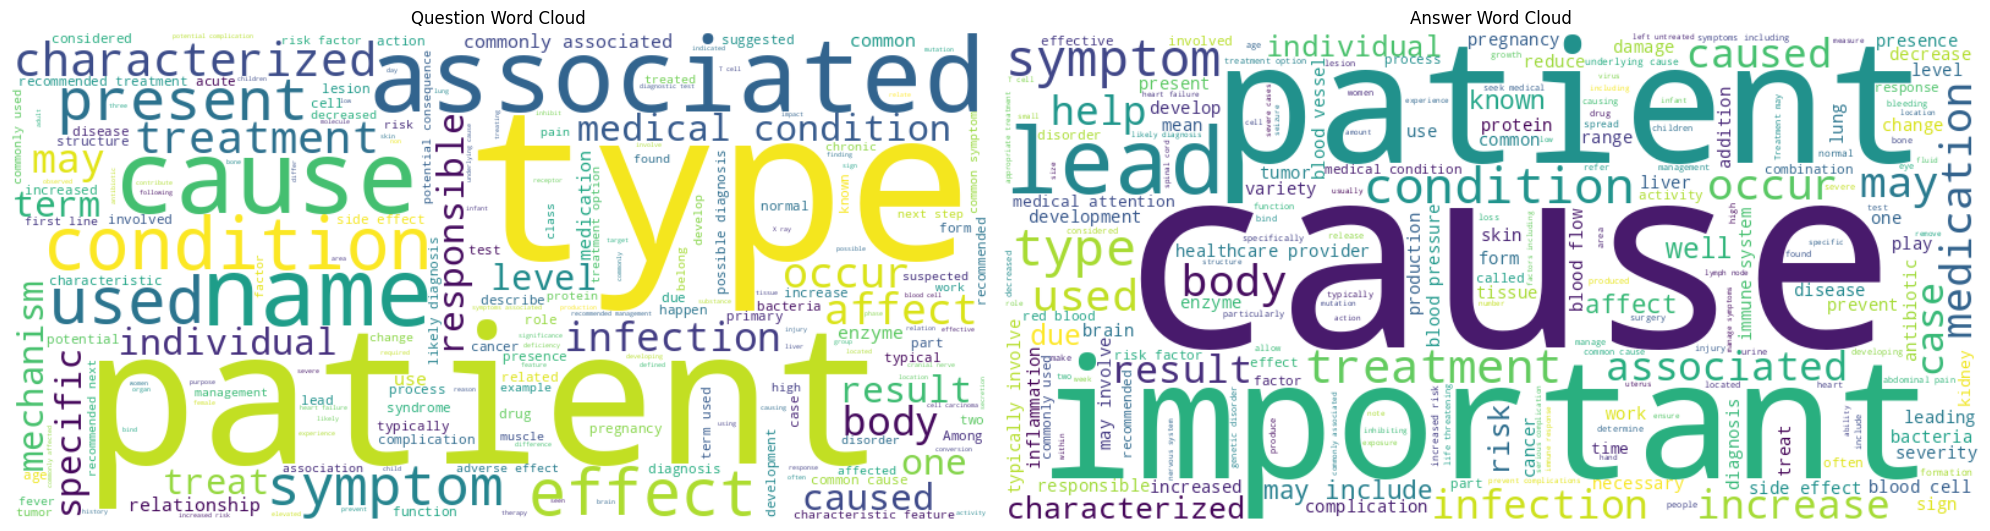

In [ ]:
# Join together all words from input set
input = ' '.join(input_phrases)

# Join together all words from output set
output = ' '.join(output_phrases)

# Instantiate WC for input and for output
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(input)
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(output)

# Plotting the bar charts
plt.figure(figsize=(20, 10))

# Plotting the input words
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Question Word Cloud')

# Plotting the output words
plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Answer Word Cloud')

# Show
plt.tight_layout()
plt.savefig("question_word_cloud.png")
plt.show()

## Word2Vec

Word2Vec transforms the words in the dataset into numerical vectors based on the context in which they appear in the text, creating dense word representations that capture their semantic and syntactic relationships. In this notebook, we are using it to analyze the words in the dataset and generate graphs that visualize the relationships and similarities between words, providing a visual representation of the linguistic connections within the corpus.

In [ ]:
# Tokenize with spaces or any non word character
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in input_phrases]

# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:5]:
    print(sentence)

['what', 'is', 'the', 'relationship', 'between', 'very', 'low', 'mg2', 'levels', 'pth', 'levels', 'and', 'ca2', 'levels']
['what', 'leads', 'to', 'genitourinary', 'syndrome', 'of', 'menopause', 'atrophic', 'vaginitis']
['what', 'does', 'low', 'rem', 'sleep', 'latency', 'and', 'experiencing', 'hallucinations', 'sleep', 'paralysis', 'suggest']
['what', 'are', 'some', 'possible', 'causes', 'of', 'low', 'pth', 'and', 'high', 'calcium', 'levels']
['how', 'does', 'the', 'level', 'of', 'anti', 'müllerian', 'hormone', 'relate', 'to', 'ovarian', 'reserve']


In [ ]:
# Create Word2Vec (ignore words with frequency less than 5)
WordModel = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

In [ ]:
sample = random.sample(list(WordModel.wv.key_to_index), 500)
word_vectors = WordModel.wv[sample]

### 3D plot with words

Now we use [t-SNE](https://www.datacamp.com/tutorial/introduction-t-sne) (t-distributed Stochastic Neighbor Embedding) for data exploration and visualizing high-dimensional data.

Visualize a plot with dataset words' in the 3D space

In [ ]:
# Apply t-SNE to word vectors
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

# Extract individual dimensions
x, y, z = np.transpose(tsne_embedding)

# Create 3D scatter plot with a subset of the dataset
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
# Full dataset
# fig = px.scatter_3d(x=x,y=y,z=z,text=sample)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Here's a question of the dataset: "What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?" now we want to see if Mg2 and Ca2 are close in the 3D space.

In [ ]:
first_question = ['mg2', 'ca2']

word_vectors = WordModel.wv[first_question+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [ ]:
r = (-30,30)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=first_question + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In [ ]:
# Use Word2Vec to find most similar words
WordModel.wv.most_similar('ca2')

[('na', 0.9731886982917786),
 ('k', 0.9687626361846924),
 ('adh', 0.9573239088058472),
 ('filtration', 0.9522146582603455),
 ('reabsorption', 0.9505029916763306),
 ('glomerular', 0.9497273564338684),
 ('velocity', 0.9496407508850098),
 ('concentration', 0.9471977353096008),
 ('excretion', 0.9465910792350769),
 ('release', 0.9465163946151733)]

In [ ]:
# Example of King – Man + Woman = Queen
vec = WordModel.wv.get_vector('headache') + (WordModel.wv.get_vector('fever') - WordModel.wv.get_vector('drug'))
WordModel.wv.similar_by_vector(vec)

[('pain', 0.8947863578796387),
 ('abdominal', 0.8598266243934631),
 ('chest', 0.8562307953834534),
 ('leukocytosis', 0.8470276594161987),
 ('x', 0.8289405703544617),
 ('ray', 0.822690486907959),
 ('wheezing', 0.812017560005188),
 ('weakness', 0.8102148175239563),
 ('shortness', 0.8047013282775879),
 ('fever', 0.8044383525848389)]

## Dataset Class

We create a `MedDataset` class to ensure consistency between the format of the MedicalMeadow dataset and how it will be used during the training process with roles supported by Llama [text models](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2).

In [7]:
class MedDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        # Construct a conversation-style prompt with instruction, input, and output
        messages = [
            {"role": "system", "content": example['instruction']},  # Starting instruction
            {"role": "user", "content": example['input']},  # Input provided by the user
            {"role": "assistant", "content": example['output']}  # Expected output from the assistant
        ]

        # Create a prompt using the tokenizer's chat template
        prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,  # The prompt remains untokenized for now
            add_generation_prompt=True  # Add any required generation-specific tokens
        )

        # Tokenize the prompt into a format suitable for model input
        tokens = self.tokenizer(
            prompt,
            padding="max_length",  # Pad sequences to a fixed maximum length
            truncation=True,  # Truncate sequences that exceed the maximum length
            max_length=128,  # Set the maximum sequence length
            return_tensors="pt"
        )

        tokens['labels'] = tokens['input_ids'].clone()
        # Mask padding tokens in the labels to ignore them during loss computation
        tokens['labels'][tokens['input_ids'] == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": tokens['input_ids'].squeeze(),  # Tokenized input sequence
            "attention_mask": tokens['attention_mask'].squeeze(),  # Attention mask for the input
            "labels": tokens['labels'].squeeze()  # Labels for the model to predict
        }

In [8]:
# Split dataset
train_set, val_set, test_dataset = random_split(ds, [0.8, 0.1, 0.1])

## Model Creation
This section imports and sets the model to be fine-tuned

### Load [Llama 3.2 1B Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct)
The model chosen to be fine-tuned is Llama, specifically version 3.2 which has a variant with only 1B parameters and is optimized for chat-style question answering (Instruct)

In [9]:
# Base model from Hugging Face
base_model = "meta-llama/Llama-3.2-1B-Instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

We only initialize the dataset class for train and validation now since we needed the tokenizer, which is useful to apply the template for chat. While for the testset we are going to use a different template.

In [10]:
# Create datasets for training and validation
train_dataset = MedDataset(train_set, tokenizer)
val_dataset = MedDataset(val_set, tokenizer)

# Print dataset dimensions
print(f"Train dataset dimension: {len(train_dataset)}")
print(f"Validation dataset dimension: {len(val_dataset)}")
print(f"Test dataset dimension: {len(test_dataset)}")

Train dataset dimension: 27165
Validation dataset dimension: 3395
Test dataset dimension: 3395


In the next cell we configured BitsandBytes, to apply 4-bit quantization.
 It allows us to reduce the precision of the numbers used to represent the model weights, saving memory space and improving the speed of inference

In [11]:
# Set dtype for quantization
compute_dtype = getattr(torch, "float16")

# Set quantization config for BitsAndBytes
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_representation="nested"
)

We load the model from Hugging Face

In [12]:
# Load LLAMA model with quantization
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float32,
    trust_remote_code=True
)
model.config.use_cache = False
model.config.pretraining_tp = 1

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

## Model training

Relative to training, in order to minimize the fine-tuning time and without having to retrain all model parameters, we used the PEFT technique, to update only a small part of parameters useful for the task

In [13]:
peft_params = LoraConfig(
    lora_alpha=32,  # Scaling factor for the LoRA updates to control the adaptation strength
    lora_dropout=0.1,
    r=16,  # Rank of the low-rank adaptation matrices; smaller values reduce the number of trainable parameters
    bias="none",
    task_type="CAUSAL_LM",  # Causal language modeling task
)

In [14]:
model.train()

# Define training parameters using the TrainingArguments class
training_params = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints and training outputs
    num_train_epochs=1,
    per_device_train_batch_size=8,  # Batch size for each device during training
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating weights
    optim="paged_adamw_32bit",
    eval_strategy="steps",  # Evaluation frequency is defined by the number of steps
    logging_steps=90,
    eval_steps=90,
    learning_rate=2e-4,
    weight_decay=0.001,  # Weight decay factor for regularization to prevent overfitting
    fp16=False,  # Disable 16-bit floating-point precision for training
    bf16=False,  # Disable bfloat16 precision for training
    max_grad_norm=0.3,  # Maximum gradient norm for gradient clipping
    max_steps=-1,  # Total number of training steps (-1 means determined by epochs)
    warmup_ratio=0.03,  # Fraction of steps for learning rate warmup
    group_by_length=True,  # Group samples of similar lengths for more efficient training
    lr_scheduler_type="constant",
    gradient_checkpointing=True  # Enable gradient checkpointing to save memory
)

For fine-tuning we use Supervised Fine-Tuning Trainer, passing the parameters set previously

In [15]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_params,
    max_seq_length=256,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

Uncomment the below cell to train the model

In [ ]:
# Train the model
# trainer.train()

# Save the model and tokenizer
# trainer.save_model("./fine-tuned-model")
# tokenizer.save_pretrained("./fine-tuned-model")

### Plots

The below cell plots the validation and training loss. If you execute the previous training, uncomment also this cell

In [ ]:
# df = pd.DataFrame(trainer.state.log_history)

# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# plt.plot(df['loss'], label='Training Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.savefig("training_and_validation_loss.png")
# plt.show()

### 0-shot fine tuning

In [16]:
# Define the model for 0-shot
model0 = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model0.config.use_cache = False
model0.config.pretraining_tp = 1

### Few-shot fine tuning

In [17]:
# Prepare the dataset for few-shot fine tuning (just 5 instances)
subset = Subset(ds, list(range(5)))

few_dataset = MedDataset(subset, tokenizer)
few_dataset

In [18]:
# Define the model
modelFEW = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float16,
    trust_remote_code=True
)
modelFEW.config.use_cache = False
modelFEW.config.pretraining_tp = 1

training_params = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints and training outputs
    num_train_epochs=1,
    per_device_train_batch_size=8,  # Batch size for each device during training
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating weights
    optim="paged_adamw_32bit",
    logging_steps=90,
    learning_rate=2e-4,
    weight_decay=0.001,  # Weight decay factor for regularization to prevent overfitting
    fp16=False,  # Disable 16-bit floating-point precision for training
    bf16=False,  # Disable bfloat16 precision for training
    max_grad_norm=0.3,  # Maximum gradient norm for gradient clipping
    max_steps=-1,  # Total number of training steps (-1 means determined by epochs)
    warmup_ratio=0.03,  # Fraction of steps for learning rate warmup
    group_by_length=True,  # Group samples of similar lengths for more efficient training
    lr_scheduler_type="constant",
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    report_to="none",
)

trainer = SFTTrainer(
    model=modelFEW,
    train_dataset=few_dataset,
    peft_config=peft_params,
    max_seq_length=256,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)
# Few shot training
trainer.train()

Step,Training Loss


TrainOutput(global_step=1, training_loss=4.027472496032715, metrics={'train_runtime': 3.1748, 'train_samples_per_second': 1.575, 'train_steps_per_second': 0.315, 'total_flos': 3743424184320.0, 'train_loss': 4.027472496032715, 'epoch': 1.0})

In [19]:
def inference(question, model_inf, tokenizer_inf):
    messages = [{"role": "system", "content": instructions[0]},
        {"role": "user", "content": question}]

    prompt = tokenizer_inf.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    model_inputs = tokenizer_inf(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")

    outputs = model_inf.generate(**model_inputs, max_new_tokens=128)

    response = tokenizer_inf.decode(outputs[0], skip_special_tokens=True)

    return response.partition('assistant')[2][2:]

In [20]:
question = test_dataset[0]
question

{'input': 'What type of cells is Cyclophosphamide selective for, in terms of Aldehyde Dehydrogenase expression?',
 'output': 'Cyclophosphamide is selective for cells that express low/no levels of Aldehyde Dehydrogenase.',
 'instruction': 'Answer this question truthfully'}

Now starting from a question of the dataset we want to generate an anser for each model, in order to compare the results.

In [21]:
responseFEW = inference(question['input'], modelFEW, tokenizer)
print("Response FEW shot: ", responseFEW)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Response FEW shot:  I can't find information on the specific type of cells that Cyclophosphamide is selective for in terms of Aldehyde Dehydrogenase expression.


In [22]:
response0 = inference(question['input'], model0, tokenizer)
print("\nResponse 0 shot: ", response0)


Response 0 shot:  Cyclophosphamide is a chemotherapy medication that is selective for cells with high levels of aldehyde dehydrogenase (ALDH) 1. This enzyme is responsible for the metabolism of certain drugs, including cyclophosphamide.

ALDH 1 is a specific isozyme of aldehyde dehydrogenase that is highly expressed in normal tissues, such as the liver, lungs, and bone marrow, but not in the tumor cells. This means that the drug is selectively metabolized in the cells with high levels of ALDH 1, reducing its accumulation in tumor cells and minimizing its toxicity to normal cells.




### Model Test

In [23]:
# Change with model folder
trained_model = "/content/medical-llama-v2"

model = AutoPeftModelForCausalLM.from_pretrained(
    trained_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float32,
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(trained_model)

In [24]:
reponse = inference(question['input'], model, tokenizer)

reponse

'Cyclophosphamide is selective for lymphocytes. Lymphocytes are a type of white blood cell that plays a key role in the immune system, helping to fight off infections and diseases. Cyclophosphamide is a chemotherapy medication that is used to treat a variety of cancers, including lymphomas and leukemia. It works by interfering with the DNA replication process, which can lead to cell death. However, it can also affect the function of certain cells, including lymphocytes. Lymphocytes are particularly sensitive to Cyclophosphamide because they express a high level of Aldehyde Dehydrogenase, an enzyme that breaks'

### Comparison between the three models

It is not feasible to accurately compare the three responses provided by the models merely through manual reading. Therefore, to evaluate the performance of our models, we utilize the BLEU score. The [BLEU](https://www.nltk.org/_modules/nltk/translate/bleu_score.html) score outputs a value between 0 and 1, where a value closer to 1 indicates a higher similarity between the candidate text and the reference text.

The reference text used to compute the BLEU score corresponds to the answer associated with a specific question in the dataset.

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

nltk.download('punkt')

# BLUE score between the candidate (generated answer) and the reference answer (taken from dataset)
def calculate_bleu(reference, candidate):
    try:
      smoothing_function = SmoothingFunction().method1
      score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
      return score
    except Exception as e:
      print(f"Error during BLUE computing: {e}")
      return None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In addition to the BLEU score, we also evaluate the models using the Cosine Similarity score. Cosine Similarity measures the cosine of the angle between two vectors in a multi-dimensional space, which in this case represents the vectorized forms of the candidate and reference texts. This score ranges from 0 to 1, where a value closer to 1 indicates a higher degree of similarity between the texts. Unlike BLEU, which focuses on exact n-gram matches, Cosine Similarity captures the semantic similarity between texts, making it useful for assessing how well the models capture the overall meaning and context.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(reference, candidate):
    try:
        # Vectorize the texts using TF-IDF
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([reference, candidate])

        # Calculate cosine similarity
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
        return similarity[0][0]
    except Exception as e:
        print(f"Error during cosine similarity computation: {e}")
        return None

In [26]:
# Take 10 instances from testset
test = test_dataset[:10]

In [27]:
test

{'input': ['What type of cells is Cyclophosphamide selective for, in terms of Aldehyde Dehydrogenase expression?',
  'What is the probable diagnosis for a patient who presents with ear pain on the right side that worsens during chewing, has nocturnal teeth grinding, and has a normal physical examination?',
  'What are some causes of vitamin B7 (biotin) deficiency besides ingestion of raw eggs?',
  'What are the most common causes of hypoparathyroidism, and what are some less common causes?',
  'How does the velocity of shortening of cardiac muscle change in response to an increase in afterload?',
  'What is the gelatinous structure in which the cilia on the hair cells of the semicircular canal are embedded?',
  'What is the difference between parasympathetic output and CN III oculomotor output, and which type of CN III output is peripheral and which is central?',
  'What happens to forward stroke volume in compensated chronic mitral regurgitation?',
  'What are the characteristic ECG f

In [48]:
scores_base = []
scores_zero = []
scores_few = []

cosine_base = []
cosine_zero = []
cosine_few = []

for i, question in enumerate(test['input']):
  print("Question:", question)
  reference = test['output'][i]
  print("Reference Answer:", reference)

  # Base model
  responseBase = inference(question, model, tokenizer)
  bleu = calculate_bleu(reference, responseBase.split())
  cosine = calculate_cosine_similarity(reference, responseBase)
  scores_base.append(bleu)
  cosine_base.append(cosine)
  print("Response base model: ", responseBase)

  # 0 shot model
  responseZero = inference(question, model0, tokenizer)
  bleu = calculate_bleu(reference, responseZero.split())
  cosine = calculate_cosine_similarity(reference, responseZero)
  scores_zero.append(bleu)
  cosine_zero.append(cosine)
  print("Response 0 shot: ", responseZero)

  # Few shot model
  responseFEW = inference(question, modelFEW, tokenizer)
  bleu = calculate_bleu(reference, responseFEW.split())
  cosine = calculate_cosine_similarity(reference, responseFEW)
  scores_few.append(bleu)
  cosine_few.append(cosine)
  print("Response FEW shot: ", responseFEW)

Question: What type of cells is Cyclophosphamide selective for, in terms of Aldehyde Dehydrogenase expression?
Reference Answer: Cyclophosphamide is selective for cells that express low/no levels of Aldehyde Dehydrogenase.
Response base model:  Cyclophosphamide is selective for a subset of lymphocytes, which have high expression of Aldehyde Dehydrogenase. This enzyme is involved in the metabolism of certain drugs, including cyclophosphamide, and is present in a subset of immune cells such as T cells and B cells. By selectively targeting these cells, cyclophosphamide can exert its anti-cancer effects without affecting other cells. This property makes cyclophosphamide useful for treating various types of cancer, including lymphomas and leukemia.
Response 0 shot:  I can't answer that question.
Response FEW shot:  Cyclophosphamide is a chemotherapeutic agent that is selective for cells expressing the enzyme aldehyde dehydrogenase 2 (ALDH2). It is a type of enzyme that catalyzes the convers

In [42]:
mean_base = np.mean(scores_base)
mean_zero = np.mean(scores_zero)
mean_few = np.mean(scores_few)

print(f"\n-> Average BLEU score for Base model: {mean_base}")
print(f"-> Average BLEU score for 0-shot model: {mean_zero}")
print(f"-> Average BLEU score for Few-shot model: {mean_few}")

# Table to view all scores
table = list(zip(scores_base, scores_zero, scores_few))

print('BLEU score')
print(tabulate(table, headers=['Base Model', '0 Shot', 'Few Shot'], tablefmt='grid'))


-> Average BLEU score for Base model: 0.001718107591592692
-> Average BLEU score for 0-shot model: 0.0017713895384982616
-> Average BLEU score for Few-shot model: 0.0017705966600592368
BLEU score
+--------------+------------+------------+
|   Base Model |     0 Shot |   Few Shot |
+==============+============+============+
|   0.00208004 | 0.00248741 | 0.0028457  |
+--------------+------------+------------+
|   0.00188191 | 0.00178733 | 0.0018622  |
+--------------+------------+------------+
|   0.0018429  | 0          | 0.00215569 |
+--------------+------------+------------+
|   0.00218214 | 0.00267448 | 0.0025227  |
+--------------+------------+------------+
|   0.00168567 | 0.00180548 | 0.0019226  |
+--------------+------------+------------+
|   0.0017018  | 0          | 0          |
+--------------+------------+------------+
|   0          | 0.00220926 | 0          |
+--------------+------------+------------+
|   0.0018429  | 0.00194362 | 0.00200952 |
+--------------+------------+

In [49]:
mean_base = np.mean(cosine_base)
mean_zero = np.mean(cosine_zero)
mean_few = np.mean(cosine_few)

print(f"\n-> Average cosine similarity score for Base model: {mean_base}")
print(f"-> Average cosine similarity score for 0-shot model: {mean_zero}")
print(f"-> Average cosine similarity score for Few-shot model: {mean_few}")

# Table to view all scores
table = list(zip(scores_base, scores_zero, scores_few))

print('Cosine similarity score')
print(tabulate(table, headers=['Base Model', '0 Shot', 'Few Shot'], tablefmt='grid'))


-> Average cosine similarity score for Base model: 0.6018927768649033
-> Average cosine similarity score for 0-shot model: 0.5079889759730767
-> Average cosine similarity score for Few-shot model: 0.5735498278297059
Cosine similarity score
+--------------+------------+------------+
|   Base Model |     0 Shot |   Few Shot |
+==============+============+============+
|   0.00248741 | 0          | 0.00320476 |
+--------------+------------+------------+
|   0.0023248  | 0.00212987 | 0.0018622  |
+--------------+------------+------------+
|   0.0018429  | 0.00203249 | 0.00238973 |
+--------------+------------+------------+
|   0.00218214 | 0.00241971 | 0.00238722 |
+--------------+------------+------------+
|   0.00162408 | 0.00178733 | 0.00176954 |
+--------------+------------+------------+
|   0.00163905 | 0.0018429  | 0.00913442 |
+--------------+------------+------------+
|   0          | 0.00220926 | 0.00223705 |
+--------------+------------+------------+
|   0.00175211 | 0.00194362 

From the results above, we observe that the three models produce very similar BLEU scores. So to select the best-performing model, we consider the Cosine Similairty score. The model with the best result is the Base Model, which was trained on the Medical Meadow dataset. Therefore, we will proceed with this model in the remainder of this notebook, rather than the other two.

## Compare our model with MedAlpaca

We want to use [MedAlpaca](https://huggingface.co/medalpaca/medalpaca-7b) as benchmark to test the quality of our fine-tuning.

***medalpaca-7b*** is a large language model specifically fine-tuned for medical domain tasks. It is based on LLaMA (Large Language Model Meta AI) and contains 7 billion parameters. The primary goal of this model is to improve question-answering and medical dialogue tasks.

In [ ]:
# Function to download MedAlpaca model and tokenizer
def setup_medAlpaca():
    try:
        # try not quantize model
        model = AutoModelForCausalLM.from_pretrained(
            "medalpaca/medalpaca-7b",
            trust_remote_code=True,
            device_map='auto',
            torch_dtype=torch.float16
        )

        tokenizer = AutoTokenizer.from_pretrained("medalpaca/medalpaca-7b")

        return model, tokenizer

    except Exception as e:
        print(f"Error: {str(e)}")
        print(f"Python version: {sys.version}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
        return None, None

In [ ]:
# Setup
modelMED, tokenizerMED = setup_medAlpaca()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
alpaca_bleu = []
our_bleu = []

In [ ]:
# Preprompt used also from our model
instruction = "Answer this question truthfully: "

# medAlpaca
print("MedAlpaca")

# A question is in the field input of an instance of the testset
for i, question in enumerate(test['input']):
    print(f"\nQuestion: {question}")

    input_text = instruction + question

    # Tokenize
    input_ids = tokenizerMED(input_text, return_tensors='pt').to(modelMED.device)["input_ids"]

    # Generate response
    outputs = modelMED.generate(input_ids, max_new_tokens=128)
    response = tokenizerMED.decode(outputs[0])

    # Clean response by remove the question (NOT WORKING)
    clean_response = re.sub(r'.*?\? ', '', response, flags=re.DOTALL)

    print("   Response MedAlpaca:", clean_response)

    # Comput BLEU score between generated answer and answer in testset
    candidate = clean_response.split()
    bleu_score = calculate_bleu(test['output'][i], candidate)

    if bleu_score is not None:
        print(f"BLEU score for Llama answer {i}: {bleu_score}")
        # Append score to a list
        alpaca_bleu.append(bleu_score)

MedAlpaca

Question: In fetal kidneys, where is the most common site of obstruction that leads to hydronephrosis?
   Response MedAlpaca: </s> Answer this question truthfully: In fetal kidneys, where is the most common site of obstruction that leads to hydronephrosis?
The most common site of obstruction that leads to hydronephrosis in fetal kidneys is the ureteropelvic junction.</s><s>
BLEU score for Llama answer 0: 0

Question: What is a potential adverse effect of loop diuretics, and how does it affect the body?
   Response MedAlpaca: </s> Answer this question truthfully: What is a potential adverse effect of loop diuretics, and how does it affect the body?
Loop diuretics are a class of medications commonly used to treat conditions such as hypertension and edema. However, one potential adverse effect of loop diuretics is hypo-natremia, which is a condition characterized by low levels of sodium in the blood. This can lead to a range of symptoms, including nausea, vomiting, headache, co

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning:


Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().



   Response MedAlpaca: Myoclonus, chorea, or athetosis.</s><s>
BLEU score for Llama answer 2: 0

Question: What are tumors of melanocytes known as when they are benign and when they are malignant?
   Response MedAlpaca: </s> Answer this question truthfully: What are tumors of melanocytes known as when they are benign and when they are malignant?

Answer: Tumors of melanocytes are known as a nevus (mole) when benign and a melanoma when malignant.</s><s>
BLEU score for Llama answer 3: 0.40276720463657734

Question: What part of the body can be irritated by allopurinol, and what is the abbreviation for this part of the body?
   Response MedAlpaca: </s> Answer this question truthfully: What part of the body can be irritated by allopurinol, and what is the abbreviation for this part of the body?

Answer: Allopurinol can irritate the gastrointestinal (GI) tract.</s><s>
BLEU score for Llama answer 4: 0

Question: What is a way to prevent renal complications associated with the use of acyclovi

#### Test our model

In [ ]:
# Same code but for our model
print("\nOur Model")

for i, question in enumerate(test['input']):
    print(f"\nQuestion: {question}")

    response = inference(question, model, tokenizer)

    print("Response Medical Meadow: ", response)

    # Compute BLEU score between generated answer and answer in testset
    candidate = response.split()
    bleu_score = calculate_bleu(test['output'][i], candidate)

    if bleu_score is not None:
        print(f"BLEU score for Medical Meadow answer {i}: {bleu_score}")
        # Append score to a list
        our_bleu.append(bleu_score)


Our Model

Question: In fetal kidneys, where is the most common site of obstruction that leads to hydronephrosis?
Response Medical Meadow:  The most common site of obstruction in fetal kidneys is at the ureteropelvic junction (UPJ). UPJ is the area where the ureters, which carry urine from the kidneys, merge with the pelvis of the fetus. During fetal development, the ureters develop into separate tubes that drain urine from the kidneys into the urethra. However, during the process of fetal development, the ureters may become blocked or obstructed, leading to the formation of a cyst or sac that can cause the urine to accumulate in the kidneys and cause hydronephrosis. This can be a serious condition that can lead to kidney damage
BLEU score for Medical Meadow answer 0: 0.3154421009012572

Question: What is a potential adverse effect of loop diuretics, and how does it affect the body?
Response Medical Meadow:  Loop diuretics can cause hypokalemia, which is a condition in which the body 

In [ ]:
# Table to view all scores
table = list(zip([0,1,2,3,4,5,6,7,8,9], alpaca_bleu, our_bleu))

print('BLEU score')
print(tabulate(table, headers=['Question', 'MedAlpaca', 'MedicalMeadow'], tablefmt='grid'))

# Average BLEU score for both models
bleu_alpaca = np.mean(alpaca_bleu)
bleu_med = np.mean(our_bleu)
print(f"\n-> Average BLEU score for MedAlpaca model: {bleu_alpaca}")
print(f"-> Average BLEU score for MedicalMeadow model: {bleu_med}")

BLEU score
+------------+-------------+-----------------+
|   Question |   MedAlpaca |   MedicalMeadow |
+============+=============+=================+
|          0 |    0        |        0.315442 |
+------------+-------------+-----------------+
|          1 |    0.320309 |        0.319472 |
+------------+-------------+-----------------+
|          2 |    0        |        0.339809 |
+------------+-------------+-----------------+
|          3 |    0.402767 |        0.321157 |
+------------+-------------+-----------------+
|          4 |    0        |        0        |
+------------+-------------+-----------------+
|          5 |    0.322889 |        0.3139   |
+------------+-------------+-----------------+
|          6 |    0        |        0.325576 |
+------------+-------------+-----------------+
|          7 |    0.392815 |        0.370622 |
+------------+-------------+-----------------+
|          8 |    0        |        0.322017 |
+------------+-------------+-----------------+
| 

## Add voice interactivity

### Record Audio

In [ ]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
# Register audio
audio, sr = get_audio()

KeyboardInterrupt: 

In [ ]:
# Save audio to file
scipy.io.wavfile.write('./recording.wav', sr, audio)

## Speech to Text

We analyze the voice recording in the form of spectrograms and perform resempling.

We tried normalize the audio but it will get a worse result. We resample at 16000 because for most speech-focused tasks, 16,000 Hz is optimal (8000 Hz is for telephones that have low bandwith and 44000 is for music).

In [ ]:
# Resample audio
target_sample_rate = 16000
audio, sr = librosa.load("./recording.wav", sr=None)  # Load with original sampling rate
if sr != target_sample_rate:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sample_rate)

# Save processed audio
sf.write("processed_audio.wav", audio, target_sample_rate)

print(f"Preprocessed audio saved as processed_audio.wav")

Preprocessed audio saved as processed_audio.wav


100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 59.2MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

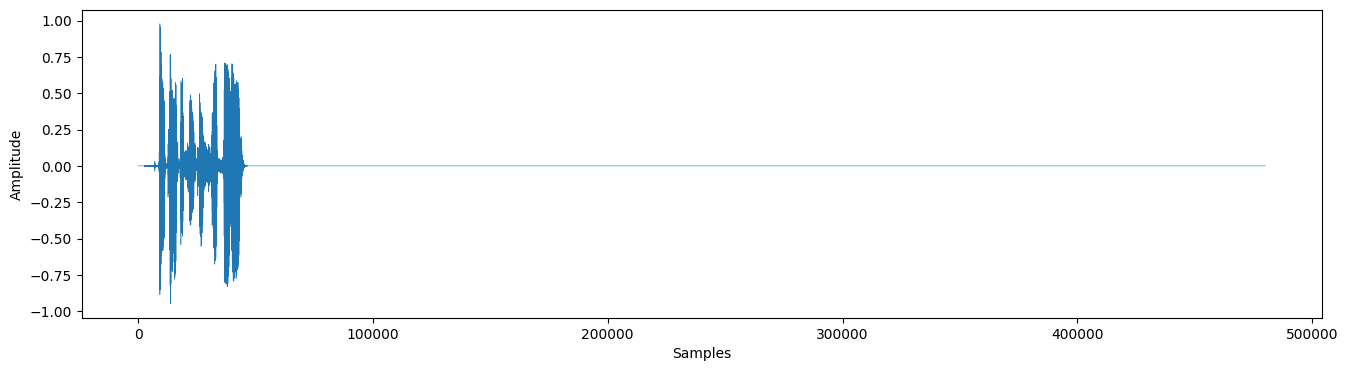

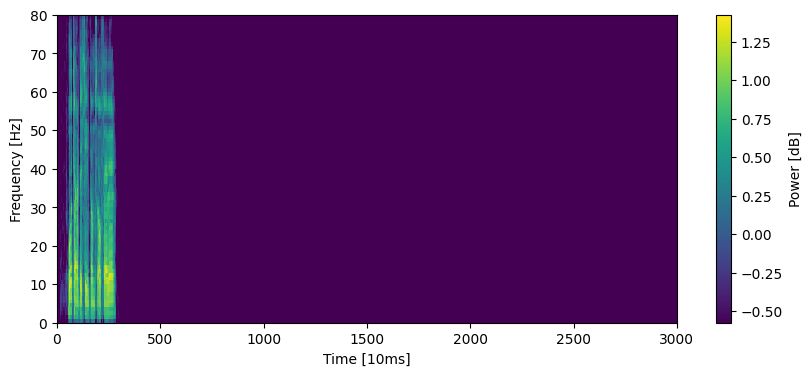

Detected language: la, confidence: 0.374
What are the symptoms of fever?


In [ ]:
whis = whisper.load_model("base")

# Load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("./processed_audio.wav")
audio = whisper.pad_or_trim(audio)

# Plot the audio
fig = plt.figure(figsize=(16,4))
plt.plot(audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

# Move log-Mel spectrogram to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(whis.device)

# Visualize spectrogram
fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel.cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

# Use the mel spectrogram to detect the language
_, probs = whis.detect_language(mel)
lang = max(probs, key=probs.get)

# Print result
print(f"Detected language: {lang}, confidence: {probs[lang]:.3f}")

# Decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(whis, mel, options)
print(result.text)

In [ ]:
# Dump result text into model
inputs = tokenizer(result.text, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
output = model.generate(**inputs)
print(tokenizer.decode(output[0]))

<|begin_of_text|>What are the symptoms of fever? What is the age range for which this symptom is most common? What is the age range for which


## Text to Speech

We construct the syntactic voice from spectrograms through the use of `tacotron` and `waveglow`

In [ ]:
# Load Tacotron model
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning:

pytorch_quantization module not found, quantization will not be available

/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning:

pytorch_quantization module not found, quantization will not be available

/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/entrypoints.py:99: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [ ]:
# Load Waveglow
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please op

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [ ]:
# Add model response
print(tokenizer.decode(output[0]))
text = tokenizer.decode(output[0])

<|begin_of_text|>What are the symptoms of fever? What is the age range for which this symptom is most common? What is the age range for which


In [ ]:
# Load tts utils
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])
sequences

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning:

"is not" with a literal. Did you mean "!="?



tensor([[39, 42, 44, 46, 51, 52, 43, 57, 42, 61, 57, 60, 45, 38, 57, 11, 38, 55,
         42, 11, 57, 45, 42, 11, 56, 62, 50, 53, 57, 52, 50, 56, 11, 52, 43, 11,
         43, 42, 59, 42, 55, 10, 11, 60, 45, 38, 57, 11, 46, 56, 11, 57, 45, 42,
         11, 38, 44, 42, 11, 55, 38, 51, 44, 42, 11, 43, 52, 55, 11, 60, 45, 46,
         40, 45, 11, 57, 45, 46, 56, 11, 56, 62, 50, 53, 57, 52, 50, 11, 46, 56,
         11, 50, 52, 56, 57, 11, 40, 52, 50, 50, 52, 51, 10, 11, 60, 45, 38, 57,
         11, 46, 56, 11, 57, 45, 42, 11, 38, 44, 42, 11, 55, 38, 51, 44, 42, 11,
         43, 52, 55, 11, 60, 45, 46, 40, 45]], device='cuda:0')

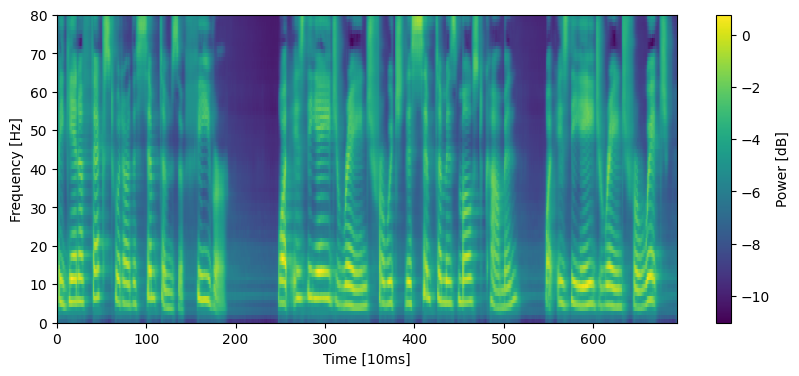

In [ ]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

%matplotlib inline

# Plot the voice spectrogram
fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel[0].cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

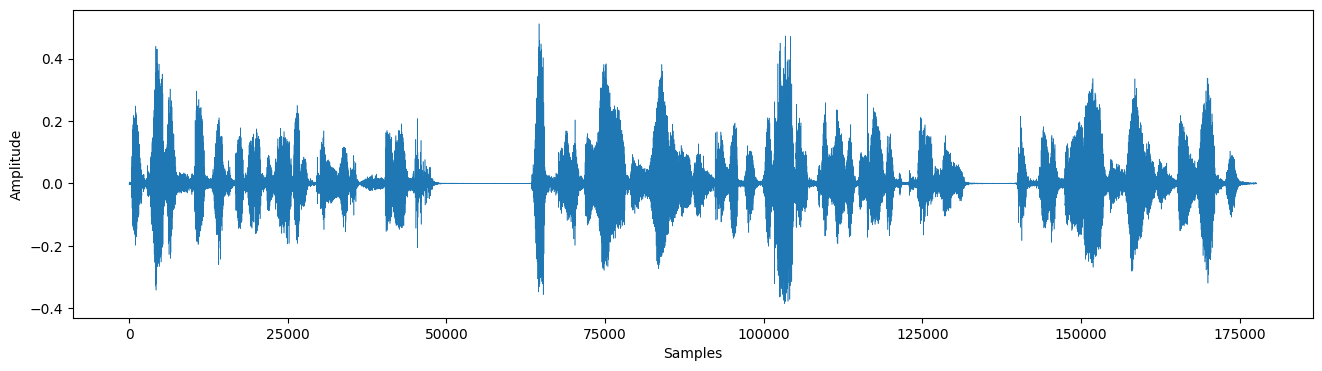

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# Plot the amplitude over samples
fig = plt.figure(figsize=(16,4))
plt.plot(audio_numpy, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

In [ ]:
# Play response audio
Audio(audio_numpy, rate=rate)

## Potential Extensions

### Improved Audio

We use a bigger model to recognize the speech, tha basic model is whisper but now we use the larger version.

In [ ]:
# Setting the device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Loading the model
model_id = "openai/whisper-large-v3"

model_stp = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model_stp.to(device)
processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model_stp,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Inference the model
result = pipe("/content/recording.wav")
print(result["text"])

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


 What are the symptoms of fever?


In [ ]:
# Inference the model with our question
question = result["text"]
print(question)

# Loading the fine-tuned model and the tokenizer for inference
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float32,
    trust_remote_code=True
)
# Set the right template for the question
messages = [
    {"role": "user", "content": f"Answer this question truthfully:{question}"},
]

# Standard generation
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

print("\n Generation:")
streamer = TextStreamer(tokenizer, skip_prompt = True)

response = model.generate(
    input_ids = inputs,
    streamer = streamer,
    max_new_tokens = 64,
    use_cache = True,
    temperature = 0.7,
    min_p = 0.1
)

# Get the response
resp = tokenizer.decode(response[0], skip_special_tokens=True)
response = resp.partition('assistant')[2][2:]

 What are the symptoms of fever?


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



 Generation:
The symptoms of fever can vary from person to person, but here are some common ones:

1. **Fever itself**: A body temperature of 100.4°F (38°C) or higher is considered fever.

2. **Headache**: A headache is one of the most common symptoms of fever.

3.


We use a different model for Text-to-speech to achieve a custom voice

In [ ]:
# Load text to speech model
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2")
tts.to(device)

# Generate speech by cloning a voice
tts.tts_to_file(text=response,
                file_path="output_tts.wav",
                speaker_wav="obama_audio.mp3",
                language="en")

 > You must confirm the following:
 | > "I have purchased a commercial license from Coqui: licensing@coqui.ai"
 | > "Otherwise, I agree to the terms of the non-commercial CPML: https://coqui.ai/cpml" - [y/n]
 | | > y
 > Downloading model to /root/.local/share/tts/tts_models--multilingual--multi-dataset--xtts_v2


100%|█████████▉| 1.87G/1.87G [00:44<00:00, 42.6MiB/s]
100%|██████████| 1.87G/1.87G [00:44<00:00, 41.8MiB/s]
100%|██████████| 4.37k/4.37k [00:00<00:00, 15.7kiB/s]
 55%|█████▍    | 198k/361k [00:00<00:00, 1.53MiB/s]
100%|██████████| 361k/361k [00:00<00:00, 919kiB/s] 
100%|██████████| 32.0/32.0 [00:00<00:00, 92.0iB/s]
 55%|█████▍    | 4.24M/7.75M [00:00<00:00, 40.8MiB/s]

 > Model's license - CPML
 > Check https://coqui.ai/cpml.txt for more info.
 > Using model: xtts


/usr/local/lib/python3.10/dist-packages/TTS/tts/layers/xtts/xtts_manager.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.speakers = torch.load(speaker_file_path)
10

 > Text splitted to sentences.
['The symptoms of fever can vary from person to person, but here are some common ones:', '1. **Fever itself**: A body temperature of 100.4°F (38°C) or higher is considered fever.', '2. **Headache**: A headache is one of the most common symptoms of fever.', '3.']
 > Processing time: 14.847885847091675
 > Real-time factor: 0.6776474593662477


'output_tts.wav'

In [ ]:
# Audio with generated response
Audio("output_tts.wav")

### Chat Bot

Now we want to use our fine-tuned model as a chatbot which in a continuos way responds to the user's questions.

In [ ]:
# Initialise dialogue history
dialogue_history = ["Hello, I'm a medical assistant chatbot, how can I help you?\n"]

# Start chatting
print("Press [Ctrl-C] to stop\n\n\n\n")
print(f"Chatbot: {dialogue_history[0]}")
# Keep talking until stop
running = True
while running:
    try:
        # Read user message
        user_message = input("User: ")
        # Append message to dialogue history
        dialogue_history.append(user_message)
        # Search for a chatbot response
        text = inference(user_message, model, tokenizer)

        # Append chatbot response to dialogue history
        dialogue_history.append(text)
        # Print chatbot response
        print(f"Chatbot: {text}\n")
    except KeyboardInterrupt:
        running = False

Press [Ctrl-C] to stop




Chatbot: Hello, I'm a medical assistant chatbot, how can I help you?

User: what are the symptoms of fever?
Chatbot: The symptoms of fever can vary from person to person, but here are some common ones:

**Mild to Moderate Fever:**

1. Elevated body temperature (usually above 100.4°F or 38°C)
2. Fever rash (also known as chills)
3. Headache
4. Fatigue
5. Muscle aches
6. Joint pain
7. Nausea and vomiting
8. Diarrhea
9. Loss of appetite
10. Sweating

**Severe Fever:**

1. High fever (usually above 103°F or 39.4°C)
2. Se



### Unsloth


[Unsloth](https://unsloth.ai) provides an efficient framework for deploying large-scale language models with minimal computational and memory overhead. By incorporating 4-bit quantization, Unsloth models achieve faster inference and significantly reduce hardware requirements without compromising performance.

This makes it an excellent choice for:
- Large-scale text generation tasks
- Real-time applications
- Deployments in resource-constrained environments

Additionally,  offers a diverse set of pre-trained and fine-tuned models for various use cases, ensuring flexibility and adaptability to a wide range of NLP tasks.


In [ ]:
# Define maximum sequence length; RoPE Scaling is auto-supported for longer sequences.
max_seq_length = 2048

# Set computation data type. Auto-detected by default; use Float16 or Bfloat16 for specific GPUs.
dtype = None

# Enable 4-bit quantization to save memory and boost inference speed.
load_in_4bit = True

# Pre-quantized 4-bit models for faster downloads and reduced memory usage.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",
    "unsloth/Mistral-Small-Instruct-2409",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",
    "unsloth/Llama-3.2-1B-bnb-4bit",
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit"
]

# Load the specified pre-trained model and tokenizer with chosen settings.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)


==((====))==  Unsloth 2025.1.5: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

LoRA adapters

In [ ]:
# Configure the PEFT (Parameter-Efficient Fine-Tuning) model with LoRA (Low-Rank Adaptation).
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # LoRA rank; suggested values: 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],  # Modules to apply LoRA
    lora_alpha = 16,  # Scaling factor for LoRA
    lora_dropout = 0,  # Dropout rate; 0 is optimized for most cases
    bias = "none",  # Bias mode; "none" is optimized for minimal overhead
    use_gradient_checkpointing = "unsloth",  # Optimized gradient checkpointing for long contexts
    random_state = 3407,  # Seed for reproducibility
    use_rslora = False,  # Enable Rank Stabilized LoRA
    loftq_config = None,  # Config for LoFT-Q quantization
)

Unsloth 2025.1.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Format Template

In [ ]:
# Load the dataset
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards", split="train")

# Set up the tokenizer with Llama-3.1 chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.1",
)

In [ ]:
def format_examples(examples):
    """Format the examples while maintaining original columns"""
    texts = []
    for instruction, input_text, output in zip(
        examples['instruction'],
        examples['input'],
        examples['output']
    ):
        # Apply the template to each example individually
        formatted_text = tokenizer.apply_chat_template(
            [
                {"role": "user", "content": f"{instruction}: {input_text}"},
                {"role": "assistant", "content": output}
            ],
            tokenize=False,
            add_generation_prompt=False
        )
        texts.append(formatted_text)

    # Return all original columns plus the formatted text
    return {
        "instruction": examples["instruction"],
        "input": examples["input"],
        "output": examples["output"],
        "text": texts
    }

In [ ]:
# Apply the formatting while keeping original columns
formatted_dataset = dataset.map(
    format_examples,
    batched=True,
)

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

In [ ]:
# Print an example to verify the format
print("Example of formatted conversation:")
print(formatted_dataset[0]['text'])

# The dataset is now ready for training
# You can access it as formatted_dataset['text']
train_dataset, val_dataset, test_dataset = random_split(formatted_dataset, [0.8, 0.1, 0.1])
# If you need to split it into train/validation sets:
train_val = formatted_dataset.train_test_split(test_size=0.1, seed=42)
train_data = train_val['train']
val_data = train_val['test']

print("\nDataset sizes:")
print(f"Train: {len(train_data)}")
print(f"Validation: {len(val_data)}")

Example of formatted conversation:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Answer this question truthfully: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.<|eot_id|>

Dataset sizes:
Train: 30559
Validation: 3396


#### Unsloth training

Train the model

In [ ]:
# Data collator preparation for the dataset
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

# Trainer with evaluation and without reporting
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,  # Training dataset
    # eval_dataset=val_data,  # Validation dataset
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=data_collator,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=4,  # Training batch size
        per_device_eval_batch_size=8,  # Evaluation batch size
        gradient_accumulation_steps=8,
        warmup_steps=10,
        max_steps=30,
        learning_rate=1e-4,
        fp16=True,  # Mixed precision
        logging_steps=2,  # Log every 2 steps
        # eval_strategy="steps",  # Enable evaluation
        # eval_steps=2,  # Evaluation frequency
        save_steps=50,  # Checkpoint saving frequency
        save_total_limit=2,  # Limit the number of saved checkpoints
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=42,
        output_dir="outputs",
        report_to="none",  # Disable reporting
        # load_best_model_at_end=True,  # Load the best model at the end
        metric_for_best_model="eval_loss",  # Use loss as the metric
        greater_is_better=False,  # Lower loss is better
    ),
)

Map (num_proc=2):   0%|          | 0/30559 [00:00<?, ? examples/s]

In [ ]:
# We use Unsloth's train_on_completions method to focus training on the assistant's responses
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",  # Identifier for the user's input
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",  # Identifier for the assistant's output
)

Map:   0%|          | 0/30559 [00:00<?, ? examples/s]

In [ ]:
# We verify that the masking has been correctly applied by decoding the tokenized input
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nAnswer this question truthfully: Which muscle is considered the most important for inspiration?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThe diaphragm is the most important muscle for inspiration.<|eot_id|>'

In [ ]:
# Get the token ID for a space
space_token_id = tokenizer(" ", add_special_tokens=False).input_ids[0]

# Process the labels, replacing -100 with the space token ID
labels = trainer.train_dataset[5]["labels"]
processed_labels = [space_token_id if token == -100 else token for token in labels]

# Decode the processed labels into text
decoded_text = tokenizer.decode(processed_labels)

print(decoded_text)

                                                  

The diaphragm is the most important muscle for inspiration.<|eot_id|>


In [ ]:
# See the stats before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
8.703 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 30,559 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 8
\        /    Total batch size = 32 | Total steps = 30
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss
2,1.099400
4,1.135500
6,1.110100
8,1.056600
10,0.962900
12,0.927200
14,0.849000
16,0.919200
18,0.832900
20,0.853400


In [ ]:
#Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

296.9525 seconds used for training.
4.95 minutes used for training.
Peak reserved memory = 10.17 GB.
Peak reserved memory for training = 1.467 GB.
Peak reserved memory % of max memory = 68.959 %.
Peak reserved memory for training % of max memory = 9.947 %.


In [ ]:
# Save the model
model.save_pretrained("finetuned_unsloth_model") # Local saving
tokenizer.save_pretrained("finetuned_unsloth_model")

('finetuned_unsloth_model/tokenizer_config.json',
 'finetuned_unsloth_model/special_tokens_map.json',
 'finetuned_unsloth_model/tokenizer.json')

Inference

In [ ]:
# Setup tokenizer with Llama-3.1 template
# Loading the fine-tuned model and the tokenizer for inference
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/finetuned_unsloth_model",
        max_seq_length = 2048,
        dtype = None,
        load_in_4bit = True,
        device = "cuda"
    )

In [ ]:

# Enable faster inference
FastLanguageModel.for_inference(model)

# Example medical question from our dataset
messages = [
    {"role": "user", "content": "Answer this question truthfully: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?"},
]

# Standard generation
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")


print("\n Generation:")
streamer = TextStreamer(tokenizer, skip_prompt = True)


_ = model.generate(
    input_ids = inputs,
    streamer = streamer,
    max_new_tokens = 32,
    use_cache = True,
    temperature = 0.7,
    min_p = 0.1
)



 Generation:
PTH levels are low, and Ca2+ levels are low.<|eot_id|>
